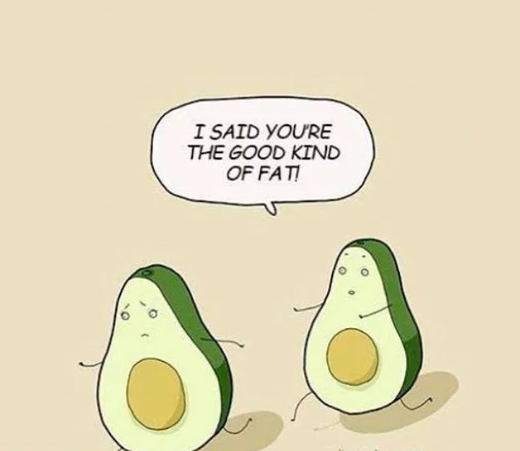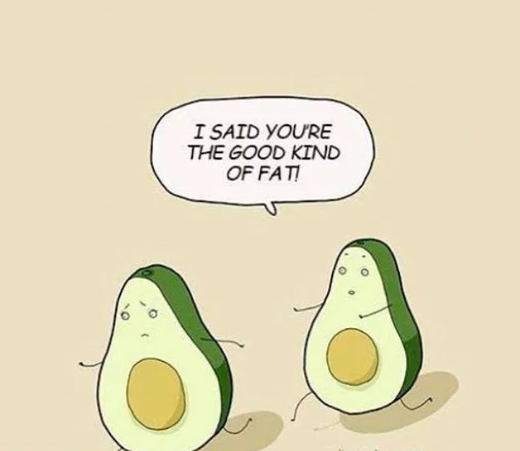

We are interested in the avocado prices and their variations throughout the year. We also want to know if there is a more popular avocado type, according to its size and weight.

There are some 'standard' questions that are worth asking:
1. What are the type of avocados that sell the most?
2. Where do they sell the most?
3. Is the avocado price stable? Does it change significantly in time? Is the price correlated with the amount of avocado sales?
4. What are the seasons when avocados sell the most? Are there specific days of the year when we can see a boost in their sales?

More specific questions may emerge in more advanced stages of this analysis.


# 1. Prepare Data

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

from datetime import datetime
from datetime import date
from datetime import timedelta

from warnings import simplefilter
simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
avocado = pd.read_csv('/kaggle/input/d/neuromusic/avocado-prices/avocado.csv');        

In [ ]:
avocado.head()

In [ ]:
print('The dataset has {} rows and {} columns.'.format(avocado.shape[0],avocado.shape[1]))

The dataset used here is from the Hass Avocado Board website (May of 2018), compiled into a single CSV file. <br>
https://www.kaggle.com/datasets/neuromusic/avocado-prices

The avocado dataset has 18249 lines and 14 rows. These are some relevant columns:

1. Date - the date of the observation
2. AveragePrice - the average price of a single avocado
3. type - conventional or organic
4. year - the year
5. Region - the city or region of the observation
6. Total Volume - total number of avocados sold
7. 4046 - total number of avocados with PLU 4046 sold
8. 4225 - total number of avocados with PLU 4225 sold
9. 4770 - total number of avocados with PLU 4770 sold

**Null and duplicate values**

In [ ]:
avocado.isna().sum()

There are no null entries in the dataframe.

In [ ]:
if avocado.duplicated().values.any():
    print("The dataset has duplicate entries.")
else:
    print('No duplicate entries in the dataframe.')

There are no duplicate entries in the dataframe.


# 2. Preprocess and Analysis

I am dropping the *Unnamed* column, because it is no use.

In [ ]:
avocado.drop(['Unnamed: 0'],axis=1,inplace=True)

**Extracting features from the date column**

The second step is to extract new features from the date column in order to make the analysis process easier.

In [ ]:
### Create column 'day of week' ###
avocado['day of week'] = pd.to_datetime(avocado['Date']).dt.strftime("%A")

### Create column 'week no.' ###
avocado['week no.'] = pd.to_datetime(avocado['Date']).dt.strftime("%U")

### Create column 'month' ###
avocado['month'] = pd.to_datetime(avocado['Date']).dt.strftime("%b")

### Create column 'season' ###
Q1 = ['Jan','Feb','Mar']
Q2 = ['Apr','May','Jun']
Q3 = ['Jul','Aug','Sep']
Q4 = ['Oct','Nov','Dec']

def month_handler(row):
    if row['month'] in Q1:
        return 'Q1'
    if row['month'] in Q2:
        return 'Q2'
    if row['month'] in Q3:
        return 'Q3'
    if row['month'] in Q4:
        return 'Q4'

avocado['season'] = avocado.apply(month_handler,axis=1)

### Create column 'year' ###
avocado['year'] = pd.to_datetime(avocado['Date']).dt.strftime("%Y")

avocado.head()

In [ ]:
avocado['year'].unique()   

 The avocado data span the 2015-2018 period. 

In [ ]:
avocado['day of week'].unique() 

All the entries were collected on Sundays. Maybe that was the day of the weekly inventory. The column 'day of week' can thus be dropped.

In [ ]:
avocado.drop(['day of week'],axis=1,inplace=True)

### Total volume

First of all, I want to make sure of the meaning of the column *Total Volume*. Is it the sum of the *4046*, *4225*, *4770* and *Total Bags* column entries? 
I can check by summing the above entries in the first row and see what I get. <br>
I also want to check if *Total Bags = Small Bags + Large Bags + XLarge Bags*.

In [ ]:
total_row0 = avocado['4046'][0] + avocado['4225'][0] + avocado['4770'][0] + avocado['Total Bags'][0]  

print("The total for row 0 is {}. This value has to be compared with the sum of the terms '4046', '4225', '4770' and 'Total Bags', which is {}.".format(avocado['Total Volume'][0],total_row0))

In [ ]:
total_bags_row0 = avocado['Small Bags'][0] + avocado['Large Bags'][0] + avocado['XLarge Bags'][0]

print("The total bags sold for row 0 amount to {}. This value has to be compared with the sum of the terms 'Small Bags', 'Large Bags' and 'XLarge Bags', which is {}.".format(avocado['Total Bags'][0],total_bags_row0))

<div class="alert alert-block alert-info"> 📌 I have verified that 'Total Volume' = '4046' + '4225' + '4770' + 'Total Bags';  'Total Bags' = 'Small Bags' + 'Large Bags' + 'XLarge Bags'.</div>

This means that the avocados are either sold separately (see the columns '4046', '4225' and '4770') or in bags, containing more pieces of fruit (see the columns 'Small Bags', 'Large Bags' and 'XLarge Bags'). The numbers displayed in the table are not integer, which means that they do no refer to the amount of pieces of fruit that was sold, but rather to their total weight (in some unit of measure) or price (in dollars). This is worth checking.

**Total volume in different time windows**

I am plotting the histograms describing the total avocado volumes in different time windows: by year, season and months. 
As discussed below, the 2018 data is limited to the first months of the year. Therefore, I am excluding 2018 data from the (total) seasonal and monthly plots not to distort the results.

In [ ]:
avocado_not2018 = avocado[avocado['year'] != 2018]
avocado_year = avocado.groupby(['year'])['Total Volume'].sum().reset_index(name='TOT/year').sort_values(['TOT/year'],ascending= False)
avocado_season = avocado_not2018.groupby(['season'])['Total Volume'].sum().reset_index(name='TOT/season').sort_values(['TOT/season'],ascending= False)
avocado_season['TOT/season'] = avocado_season['TOT/season'] / 3
avocado_month = avocado_not2018.groupby(['month'])['Total Volume'].sum().reset_index(name='TOT/month').sort_values(['TOT/month'],ascending= False)
avocado_month['TOT/month'] = avocado_month['TOT/month'] / 3

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(14,6))

ax1.bar(avocado_year['year'],avocado_year['TOT/year'],color='g',linewidth=3)
ax2.bar(avocado_season['season'],avocado_season['TOT/season'],color=['lightskyblue','limegreen','red','gold'],linewidth=3)
ax3.bar(avocado_month['month'],avocado_month['TOT/month'],color='g',linewidth=3)

ax1.set_title('Total Volume per Year',fontsize=18)
ax1.set_xlabel('year',fontsize=15)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.set_title('Total Volume by Season',fontsize=18)
ax2.set_xlabel('year quarters (seasons)',fontsize=15)
ax2.xaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)
ax3.set_title('Total Volume by Month',fontsize=18)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=11)
plt.tight_layout()
plt.show()

In [ ]:
avocado.groupby('year')['Date'].nunique().reset_index(name='no. of weeks').sort_values(['no. of weeks'],ascending= False)

As anticipated, in 2018 the data was collected for 12 weeks only (around 3 months). This is why its total volume is the smallest. <br>
In 2017 there were 53 Sundays: this is why the number of weeks is larger than in 2015 and 2016. Could this be the reason why the 2017 total volume is larger than that of 2016? Let's check.

In [ ]:
avocado.groupby('year')['Date'].max().reset_index(name='last Sunday of the year').sort_values(['last Sunday of the year'],ascending= False)

These are the last Sundays of the years 2015-2018. In 2017, the last Sunday was on New Year's Eve. Let's get the corresponding value of the daily total volume, subtract it from the 2017 total volume (so that 2017 'has 52 weeks') and then compare the 2017 corrected total volume to that of 2016.

In [ ]:
totalvolume_2016 = avocado[avocado['year'] == '2016']['Total Volume'].sum()
totalvolume_2017 = avocado[avocado['year'] == '2017']['Total Volume'].sum()
totalvolume_newyearseve_2017 = avocado[avocado['Date'] == '2017-12-31']['Total Volume'].sum()
corrected_totalvolume_2017 = totalvolume_2017 - totalvolume_newyearseve_2017

print('The total volumes of 2016 and 2017 (after correction) are {} and {}, respectively.'.format(totalvolume_2016,corrected_totalvolume_2017))
print('Their percent difference is {:.2f}%.'.format((corrected_totalvolume_2017-totalvolume_2016)/totalvolume_2016*100))

The difference in total volume between 2016 and 2017 (after correction) is very small. In other words, the total volume of 2017 is substantially the same as that of 2016.

**Top selling weeks**

People say that Americans counsume a lot of avocado (and guacamole) when they watch the Superbowl game. Let's find out if this is true by checking if the Superbowl week is among the top 5 selling weeks.

In [ ]:
week2015 = avocado[avocado['year'] == '2015'].groupby('week no.')['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending= False).head(5)
week2016 = avocado[avocado['year'] == '2016'].groupby(['week no.'])['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending= False).head(5)
week2017 = avocado[avocado['year'] == '2017'].groupby(['week no.'])['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending= False).head(5)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(14,6))

ax1.bar(week2015['week no.'],week2015['TOT/week'],color='gold',linewidth=3)
ax2.bar(week2016['week no.'],week2016['TOT/week'],color='gold',linewidth=3)
ax3.bar(week2017['week no.'],week2017['TOT/week'],color='gold',linewidth=3)

ax1.set_title('Top Selling Weeks in 2015',fontsize=18)
ax1.set_xlabel('week no.',fontsize=15)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.set_title('Top Selling Weeks in 2016',fontsize=18)
ax2.set_xlabel('week no.',fontsize=15)
ax2.xaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)
ax3.set_title('Top Selling Weeks in 2017',fontsize=18)
ax3.set_xlabel('week no.',fontsize=15)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=11)
plt.tight_layout()
plt.show()

 One can see that the fifth/sixth and 18th/19th weeks are always at the top of the sales. Let's see why these weeks are so important for the Americans. <

In 2015, the **Superbowl** match was on Sunday February 1st (5th Sunday of the year). In 2016, it was on Sunday February 7th (6th Sunday of the year). In 2017, it was on Sunday February 5th (6th Sunday of the year).


Regarding the week number 18 or 19, in 2015 the 18th Sunday was on May 10th. In 2016 the 19th Sunday was on May 8th. In 2017 the 19th Sunday was on May 7th. This could be related to **Mother's Day**: May 10th in 2015, May 8th in 2016 and May 14th in 2017.
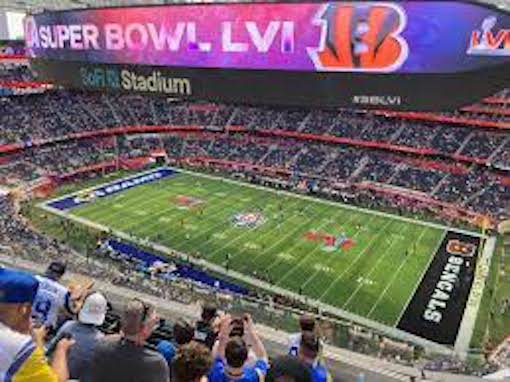

**Worst selling weeks**

In [ ]:
week2015 = avocado[avocado['year'] == '2015'].groupby('week no.')['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending= True).head(5)
week2016 = avocado[avocado['year'] == '2016'].groupby(['week no.'])['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending= True).head(5)
week2017 = avocado[avocado['year'] == '2017'].groupby(['week no.'])['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending= True).head(5)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(14,6))

ax1.bar(week2015['week no.'],week2015['TOT/week'],color='grey',linewidth=3)
ax2.bar(week2016['week no.'],week2016['TOT/week'],color='grey',linewidth=3)
ax3.bar(week2017['week no.'],week2017['TOT/week'],color='grey',linewidth=3)

ax1.set_title('Worst Selling Weeks in 2015',fontsize=18)
ax1.set_xlabel('week no.',fontsize=15)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.set_title('Worst Selling Weeks in 2016',fontsize=18)
ax2.set_xlabel('week no.',fontsize=15)
ax2.xaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)
ax3.set_title('Worst Selling Weeks in 2017',fontsize=18)
ax3.set_xlabel('week no.',fontsize=15)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=11)
plt.tight_layout()
plt.show()

As expected, the lowest selling weeks are in the last part of the year. See the 'Total Volume by Season' histogram, which shows that the fourth quarter has the lowest amount of sales.

**Sales variability**

For a grocery store manager it is extremely important to know what is the variability in avocado sales throughout the year. A possible way to calculate this kind of variability is to compute the ratio between the amount of sales (total volume) in the top and worst selling weeks. A ratio larger than a factor of 2 would indicate a large variability in the avocado sales market.

These are the maxima in week sales.

In [ ]:
maxes = avocado.groupby(['week no.','year'])['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending= False).head(10)

maxes

These are the minima in week sales.

In [ ]:
mins = avocado.groupby(['week no.','year'])['Total Volume'].sum().reset_index(name='TOT/week').sort_values(['TOT/week'],ascending=True).head(10)

mins

Now, let's compute the aforementioned min/max ratios.

In [ ]:
ratio_2015 = maxes[maxes['year'] == '2015']['TOT/week'].max() / mins[mins['year'] == '2015']['TOT/week'].min()
ratio_2016 = maxes[maxes['year'] == '2016']['TOT/week'].max() / mins[mins['year'] == '2016']['TOT/week'].min()
ratio_2017 = maxes[maxes['year'] == '2017']['TOT/week'].max() / mins[mins['year'] == '2017']['TOT/week'].min()

x = ['2015','2016','2017']
y = [ratio_2015,ratio_2016,ratio_2017]

plt.bar(x,y,color='g',linewidth=3)

plt.title('Ratio Between the Weekly Maximum and Minimum in Total Volumes',fontsize=11)
plt.xlabel('year',fontsize=12)
plt.ylabel('ratio',fontsize=12);

 The sales variability throughtout the year is high. The plot shows that the sales variability was slightly lower in 2015; in 2016 and 2017 the minimum/maximum sales ratio was similar.  

**Total volume in terms of different avocado qualities and bag sizes**

Previously we have found that: 'Total Volume' = '4046' + '4225' + '4770' + 'Total Bags'. Now we want to find out what are the relative contributions of the different avocado qualities to the total volume. We also want to check what is the composition of 'Total Bags' in terms of 'Small Bags', 'Large Bags' and 'XLarge Bags'.

In [ ]:
avocado_4046_volume = avocado['4046'].sum()
avocado_4225_volume = avocado['4225'].sum()
avocado_4770_volume = avocado['4770'].sum()
avocado_bags_volume = avocado['Total Bags'].sum()
avocado_tot = avocado['Total Volume'].sum()
avocado_bagsS = avocado['Small Bags'].sum()
avocado_bagsL = avocado['Large Bags'].sum()
avocado_bagsXL = avocado['XLarge Bags'].sum()

x1 = ['avocado 4046','avocado 4225','avocado 4770','avocado bags']
y1 = [avocado_4046_volume,avocado_4225_volume,avocado_4770_volume,avocado_bags_volume]/avocado_tot*100
x2 = ['small bags','large bags','XLarge Bags']
y2 = [avocado_bagsS,avocado_bagsL,avocado_bagsXL]/avocado_bags_volume*100

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,6))

ax1.bar(x1,y1,color='g')
ax1.set_title('Total Volume in Terms of Different Avocado Qualities',fontsize=18)
ax1.set_xlabel('avocado qualities',fontsize=15)
ax1.set_ylabel('percent',fontsize=15)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)

ax2.bar(x2,y2,color=['gold','red','blue'])
ax2.set_title('Avocado Bag Distribution (S, L and XL)',fontsize=18)
ax2.set_xlabel('bag types (sizes)',fontsize=15)
ax2.set_ylabel('percent',fontsize=15)
ax2.xaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)

plt.tight_layout()

4225 and 4046 are the most popular avocado qualities, bags are popular too. In terms of bag sizes, consumers largely prefer the small ones.

**Total volume in terms of different avocado types**

I am having a look a the avocado *type* column and then see how the avocado type is related to sales (total amounts).

In [ ]:
avocado_types = avocado.groupby('type')['Total Volume'].sum().reset_index(name='total volume by type').sort_values(['total volume by type'],ascending=True)
avocado_types_year = avocado.groupby(['type','year'])['Total Volume'].sum().reset_index(name='total volume by type').sort_values(['total volume by type'],ascending=True)

def label_function(val):
    return f'{val:.0f}%'

labels = avocado_types['type']
sizes = avocado_types['total volume by type']

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,8))

ax1.pie(sizes,labels=labels,autopct=label_function,colors=['gold','green'],textprops={'fontsize':15})
ax1.set_title('Avocado Total Volume by Type',fontsize=16)

sns.stripplot(data=avocado_types_year[avocado_types_year['year']!='2018'],x='type',y='total volume by type',hue='year',ax=ax2,s=15)
ax2.set_title('Avocado Total Volume by Type and Year',fontsize=16)
ax2.set_xlabel('avocado type',fontsize=15)
ax2.set_ylabel('total volume',fontsize=15)
ax2.xaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)

plt.tight_layout()
plt.show()

According to the data, the large majority of avocados sold in the USA are conventional (not organic).

### Price and Regions

Let's see what is the average price of avocados, what is the difference in price between organic and conventional (not organic) avocados and how the avocado price varied in the 2015-2018 time span.

**Average price**

In [ ]:
print('The average price of avocados is ${:.2f}.'.format(avocado['AveragePrice'].mean()))

In [ ]:
organic_price = avocado[avocado['type']=='organic']['AveragePrice'].mean()
conventional_price = avocado[avocado['type']=='conventional']['AveragePrice'].mean()

print('The average price of organic avocados is ${:.2f}, that of conventional avocados is ${:.2f}.'.format(organic_price,conventional_price))

The difference in price between organic and conventional avocados is around 49 cents.

In [ ]:
price_var = avocado.groupby(['year','type'])['AveragePrice'].mean().reset_index(name='mean price').sort_values(['mean price'],ascending= False)

price_var

In [ ]:
sns.catplot(data=price_var,x='type',y='mean price',hue='year',kind="bar");

The avocado price is characterized by medium-sized oscillations. Its peak was in 2017, then the price went down by around 10%.

**Correlation between price and sales (total volumes)**

Before calculating the correlation between price and total sales (total volumes), I have to make a table with the average avocado price and total sales (total volumes) by month.

In [ ]:
total_volume_month = avocado.groupby(['month','year'])['Total Volume'].sum().reset_index(name='total volume per month').sort_values(['total volume per month'],ascending=True)
avg_price_month = avocado.groupby(['month','year'])['AveragePrice'].mean().reset_index(name='monthly mean price').sort_values(['monthly mean price'],ascending=True)

avg_price_volume_month = avg_price_month.copy()
avg_price_volume_month = avg_price_volume_month.merge(total_volume_month,on=['month','year'])

avg_price_volume_month.head()

In [ ]:
sns.heatmap(avg_price_volume_month[['total volume per month','monthly mean price']].corr(),annot=True)

plt.title('Correlation Between Total Volume and Avocado Price');

There is a negative correlation between the avocado price and its total sales (volumes). This means that (on average) when the price goes up, the sales go down. 

**Regional prices**

It is interesting to see how the price of avocados changes throughout the United States.

In [ ]:
price_region = avocado.groupby(['region'])['AveragePrice'].mean().reset_index(name='avg. regional price').sort_values(['avg. regional price'],ascending= False)

price_region

 The avocado price varies significantly in different areas of the USA. The highest prices are expected either in the highest GDP per capita regions or in the areas farther north from the Mexican border (Mexico is a huge avocado producer).

In [ ]:
fig = px.histogram(price_region,x='region',y='avg. regional price',color='region',title="Average Avocado Price by USA Region")

fig.show()

**Regional sales**

In [ ]:
avocado_month_region = avocado_not2018.groupby(['month','region'])['Total Volume'].sum().reset_index(name='TOT/month').sort_values(['TOT/month'],ascending= False)
avocado_month_region['TOT/month'] = avocado_month_region['TOT/month'] / 3

avocado_month_region = avocado_month_region[avocado_month_region['region']!='TotalUS']
fig = px.histogram(avocado_month_region,x='region',y='TOT/month',color='region',title="Average Avocado Monthly Sales by USA Region")

fig.show()


# 3. Deductions

**In this analysis, we have discovered that:**

1. The first year quarter (Q1), which comprises the months of January, February and March, has the largest total volume (amount of sales) of the year. The total volume then decreases throughout the other quarters. 

In [ ]:
avocado_not2018 = avocado[avocado['year'] != 2018]
avocado_year = avocado.groupby(['year'])['Total Volume'].sum().reset_index(name='TOT/year').sort_values(['TOT/year'],ascending= False)
avocado_season = avocado_not2018.groupby(['season'])['Total Volume'].sum().reset_index(name='TOT/season').sort_values(['TOT/season'],ascending= False)
avocado_season['TOT/season'] = avocado_season['TOT/season'] / 3
avocado_month = avocado_not2018.groupby(['month'])['Total Volume'].sum().reset_index(name='TOT/month').sort_values(['TOT/month'],ascending= False)
avocado_month['TOT/month'] = avocado_month['TOT/month'] / 3

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(14,6))

ax1.bar(avocado_year['year'],avocado_year['TOT/year'],color='g',linewidth=3)
ax2.bar(avocado_season['season'],avocado_season['TOT/season'],color=['lightskyblue','limegreen','red','gold'],linewidth=3)
ax3.bar(avocado_month['month'],avocado_month['TOT/month'],color='g',linewidth=3)

ax1.set_title('Total Volume per Year',fontsize=18)
ax1.set_xlabel('year',fontsize=15)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.set_title('Total Volume by Season',fontsize=18)
ax2.set_xlabel('year quarters (seasons)',fontsize=15)
ax2.xaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)
ax3.set_title('Total Volume by Month',fontsize=18)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=11)
plt.tight_layout()
plt.show()

2. The sales variability throughtout the year is high. The plot shows that the sales variability was slightly lower in 2015; in 2016 and 2017 the minimum/maximum sales ratio was similar. <br>
The week with the highest sales is that of the Superbowl.

In [ ]:
ratio_2015 = maxes[maxes['year'] == '2015']['TOT/week'].max() / mins[mins['year'] == '2015']['TOT/week'].min()
ratio_2016 = maxes[maxes['year'] == '2016']['TOT/week'].max() / mins[mins['year'] == '2016']['TOT/week'].min()
ratio_2017 = maxes[maxes['year'] == '2017']['TOT/week'].max() / mins[mins['year'] == '2017']['TOT/week'].min()

x = ['2015','2016','2017']
y = [ratio_2015,ratio_2016,ratio_2017]

plt.bar(x,y,color='g',linewidth=3)

plt.title('Ratio Between the Weekly Maximum and Minimum in Total Volumes',fontsize=11)
plt.xlabel('year',fontsize=12)
plt.ylabel('ratio',fontsize=12);

3. The average price of organic avocados is $\$1.65$, that of conventional avocados is $\$1.16$. The 97% of the avocados sold in the USA is of conventional type.

4. There is a negative correlation between the avocado price and its total sales (volumes). This means that when the price goes up, fewer people buy avocados.

In [ ]:
sns.heatmap(avg_price_volume_month[['total volume per month','monthly mean price']].corr(),annot=True)

plt.title('Correlation Between Total Volume and Avocado Price');

5. The avocado prices vary significantly in the different areas of the USA. The highest prices are expected either in the highest GDP per capita regions or in the areas farther north from the Mexican border (Mexico is a huge avocado producer).

In [ ]:
fig = px.histogram(price_region,x='region',y='avg. regional price',color='region',title="Average Avocado Price by USA Region")

fig.show()

 <h1  id="1" style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1282C4;
           font-size:180%;
           font-family:Verdana;
           letter-spacing:0.5px"> PART II. Time Series </h1>

<a id="7"></a>
# 1. Total Sales on a Time Scale

I am grouping the total amounts (sales) by day and I am sorting them in chronological order.

In [ ]:
sales_by_day = avocado.groupby('Date')['Total Volume'].sum().reset_index(name='volume/day').sort_values(['volume/day'],ascending= False)
sorted_sales = sales_by_day.sort_values(by='Date',ascending=True)

sorted_sales

After doing this, I can plot the **daily total volumes** (i.e. daily total sales) on a time scale.

In [ ]:
dateSB1 = '2015-02-01'
dateSB2 = '2016-02-07'
dateSB3 = '2017-02-05'
dateSB4 = '2018-02-04'

dateMD1 = '2015-05-10'
dateMD2 = '2016-05-08'
dateMD3 = '2017-05-07'

fig = px.line(sorted_sales,x='Date',y='volume/day',title='Total Volumes by Day')
fig.add_vline(x=dateSB1,line_width=1,line_color="red")
fig.add_vline(x=dateSB2,line_width=1,line_color="red")
fig.add_vline(x=dateSB3,line_width=1,line_color="red")
fig.add_vline(x=dateSB4,line_width=1,line_color="red")
fig.add_vline(x=dateMD1,line_width=1,line_color="green")
fig.add_vline(x=dateMD2,line_width=1,line_color="green")
fig.add_vline(x=dateMD3,line_width=1,line_color="green")

1. It appears that the sales increased over the first two years, but then the sales trend became more or less constant (except for the inner yearly variations). This reflects our previous findings on total volumes/year of [Sec. 5](#5).
2. There are at least two peaks in the sales every year. As discussed in [Sec. 5](#5), one corresponds to the **<span style="color:crimson;"> SuperBowl match</span>** (beginning of February; red vertical lines in the plot); the second takes place around **<span style="color:green;">Mother's Day</span>** (first half of May; green vertical lines in the plot).
3. The clear two-peak yearly trend in sales was there since the begginning, but it became even wider in 2016. This means that, starting from 2016, consuming avocados on special occasions became a thing in the USA.

**Total sales for different types of avocados**

In [ ]:
sales_by_day_type = avocado.groupby(['Date','type'])['Total Volume'].sum().reset_index(name='volume/day').sort_values(['volume/day'],ascending= False)
sorted_sales_type = sales_by_day_type.sort_values(by='Date',ascending=True)

sorted_sales_type

In [ ]:
fig = px.line(sorted_sales_type,x='Date',y='volume/day',title='Total Volumes per Day',color='type')

fig.show()

As already found out in [Sec. 5](#5), the sales of conventional and organic avocados are on totally different scales. 

What we can do is to compare the variation in sales of the two types of avocados rather than their total sales. We can do this by normalizing the total avocado daily sales by dividing them by the total sales registered on the first day of this time series.

In [ ]:
day1 = sorted_sales_type['Date'].min()
norm = sorted_sales_type[sorted_sales_type['Date'] == day1]['volume/day']

norm_sales_organic = sorted_sales_type[sorted_sales_type['type'] == 'organic'].copy()
norm_sales_organic = norm_sales_organic.assign(variation = lambda x:(x['volume/day']/norm[1]))
norm_sales_organic = norm_sales_organic.drop(['volume/day'],axis=1)

norm_sales_conventional = sorted_sales_type[sorted_sales_type['type'] == 'conventional'].copy()
norm_sales_conventional = norm_sales_conventional.assign(variation = lambda x:(x['volume/day']/norm[0]))
norm_sales_conventional = norm_sales_conventional.drop(['volume/day'],axis=1)

norm_sales = pd.concat([norm_sales_conventional,norm_sales_organic]).sort_values(by='Date',ascending=True)
norm_sales.head(10)

In [ ]:
fig = px.line(norm_sales,x='Date',y='variation',title='Variation in Sales of Organic and Conventional Avocados',color='type')

fig.show()

One can notice that the sales of conventional avocados grow in the first two years and then they substantially stabilize (their yearly trend is stable). On the contrary, the sales of organic avocados are on a constant year-by-year rise for the entire 2015-2018 period. 
Even though the organic type contributes to the total sales of avocados by 3%, if these trends are confirmed organic avocados will take a more consistent share of the market in the near future.

<a id="8"></a>
# 2. Average Price on a Time Scale

I am plotting the average (daily) price on the 2015-2018 time scale. 

In [ ]:
avg_price_by_day = avocado.groupby(['Date'])['AveragePrice'].mean().reset_index(name='avg price').sort_values(['avg price'],ascending=False)
avg_price_by_day = avg_price_by_day.sort_values(by='Date',ascending=True)

fig = px.line(avg_price_by_day,x='Date',y='avg price',title='Avocado Average Price')
fig.add_vline(x=dateSB1,line_width=1,line_color="red")
fig.add_vline(x=dateSB2,line_width=1,line_color="red")
fig.add_vline(x=dateSB3,line_width=1,line_color="red")
fig.add_vline(x=dateSB4,line_width=1,line_color="red")
fig.add_vline(x=dateMD1,line_width=1,line_color="green")
fig.add_vline(x=dateMD2,line_width=1,line_color="green")
fig.add_vline(x=dateMD3,line_width=1,line_color="green")

fig.show()

The red and green lines in the plot correspond to the yearly peaks of sales (SuperBowl and Mother's Day, respectively). 
 It is worth to note that the maxima in sales correspond to minima or local minima in prices. This is an indication of the negative correlation between the two quantities. 

Now I am plotting the variation of the average price of the two avocado types, conventional and organic.

In [ ]:
avg_price_by_type = avocado.groupby(['Date','type'])['AveragePrice'].mean().reset_index(name='avg price').sort_values(['avg price'],ascending=False)
avg_price_by_type = avg_price_by_type.sort_values(by='Date',ascending=True)

fig = px.line(avg_price_by_type,x='Date',y='avg price',title='Avocado Average Price by Type',color='type')

fig.show()

The two series (for the price of organic and conventional avocados) have a similar behavior, even though their local maxima and minima are shifted; moreover, their peaks have different widths and heights.

I am creating a time series of the ratio between these quantities ...

In [ ]:
avg_price_organic = pd.DataFrame()
avg_price_conventional = pd.DataFrame()
ratio = pd.DataFrame()

avg_price_organic[['Date','avg price org']] = avg_price_by_type[avg_price_by_type['type'] == 'organic'][['Date','avg price']]
avg_price_conventional[['Date','avg price conv']] = avg_price_by_type[avg_price_by_type['type'] == 'conventional'][['Date','avg price']]

ratio = avg_price_organic.copy()
ratio = ratio.merge(avg_price_conventional,on=['Date'])
ratio['price ratio'] = ratio['avg price conv'] / ratio['avg price org']

ratio

... and now I am plotting the ratio.

In [ ]:
fig = px.line(ratio,x='Date',y='price ratio',title='Ratio Between the Prices of Conventional and Organic Avocados')

fig.show()

The price ratio increased from around 0.65 in 2015 to around 0.75 in 2018. In 2017 it went up to around 0.9, which means that organic and conventional avocados had almost the same price, even though it was for a short time.
This must be the result of a market strategy: cut the price of organic avocados in order to sell more fruit of this quality.

Let's study the correlation between organic-conventional avocado price difference and the total volumes (i.e. the total sales) of organic avocados.

In [ ]:
organic_volume_month = avocado[avocado['type'] == 'organic'].groupby(['month','year'])['Total Volume'].sum().reset_index(name='organic volume per month').sort_values(['organic volume per month'],ascending=True)
organic_price = avocado[avocado['type'] == 'organic'].groupby(['month','year'])['AveragePrice'].mean().reset_index(name='organic mean price').sort_values(['organic mean price'],ascending=True)
organic_price = organic_price.merge(organic_volume_month,on=['month','year'])
organic_price['date'] = pd.to_datetime(organic_price["month"] + "-" + organic_price["year"].astype(str))
organic_price = organic_price.sort_values(['date'],ascending=True)

conventional_volume_month = avocado[avocado['type'] == 'conventional'].groupby(['month','year'])['Total Volume'].sum().reset_index(name='conventional volume per month').sort_values(['conventional volume per month'],ascending=True)
conventional_price = avocado[avocado['type'] == 'conventional'].groupby(['month','year'])['AveragePrice'].mean().reset_index(name='conventional mean price').sort_values(['conventional mean price'],ascending=True)
conventional_price = conventional_price.merge(conventional_volume_month,on=['month','year'])
conventional_price['date'] = pd.to_datetime(conventional_price["month"] + "-" + conventional_price["year"].astype(str))
conventional_price = conventional_price.sort_values(['date'],ascending=True)

price_difference = pd.DataFrame()
price_difference['date'] = organic_price['date']
price_difference['diff. price/month'] = organic_price['organic mean price'] - conventional_price['conventional mean price']
price_difference['conventional volume per month'] = conventional_price['conventional volume per month']
price_difference['organic volume per month'] = organic_price['organic volume per month']
price_difference.head(5)

In [ ]:
sns.heatmap(price_difference[['diff. price/month','organic volume per month','conventional volume per month']].corr(),annot=True)

plt.title('Correlation Between the Difference in Prices of Conventional and Organic Avocados and Their Sales');

There is a (small) negative correlation between the difference in price of organic and conventional avocados and the organic avocado sales. There is a (small) positive correlation between the difference in price of organic and conventional avocados and the conventional avocado sales. <br>
This means that a small price difference favors the organic avocado sales.